In [1]:
import session_config
import reports
import userdisplay
import geospatial
import gridforecast as gfcast

import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt

import geopandas as gpd
import contextily as ctx
from shapely.geometry import box
from shapely.geometry import Point

import math
from matplotlib.lines import Line2D
from shapely.ops import unary_union

from myst_nb import glue
from IPython.display import display, Markdown

def display_forecast(fcast_summary):
    average = fcast_summary['average']
    hdi_min, hdi_max = fcast_summary['hdi'][0], fcast_summary['hdi'][1]
    
    range_90_min, range_90_max= fcast_summary['range'][0], fcast_summary['range'][-1]
    alist = f'\n* Average: {round(average, 2)}\n* HDI 95%: {round(hdi_min, 2)} - {round(hdi_max, 2)}\n* 90% Range: {round(range_90_min, 2)} - {round(range_90_max,2)}'
    return alist

def display_forecast_summary(asummary, label):
    forecast_summary = display_forecast(asummary)
    forecast_summary = Markdown(f'{label}{forecast_summary}')
    return forecast_summary

def extract_dates_for_labels_from_summary(summary):
    start = dt.datetime.strftime(summary.pop('start'), format=session_config.date_format)[:4]
    end = dt.datetime.strftime(summary.pop('end'), format=session_config.date_format)[:4]
    return f"{start} - {end}"

def format_boundaries_feature_inv(boundaries, topop, displayfunc, session_language='en'):
    for thingtoremove in topop:
        boundaries.pop(thingtoremove)
    display_boundaries = displayfunc(boundaries, session_language=session_language)
    return Markdown(display_boundaries)

def format_river_lake_summary(d):
    d.drop('feature_type', axis=1, inplace=True)
    d.rename(columns={'feature_name':'Name', 'sample_id': 'samples'}, inplace=True)
    d['pcs/m'] = d['pcs/m'].round(2)
    d['Name'] = d.Name.apply(lambda x: x.capitalize())
    d.set_index('Name', inplace=True)
    d.index.name = None
    return d


highlight_props = 'background-color:#FAE8E8'
def highlight_max(s, arg, props: str = highlight_props):
    return np.where((s > arg) & (s != 0), props, '')

logging.basicConfig(
    filename='app.log', 
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger(__name__)
color_style = {'prior':'color: #daa520', 'likelihood':'color: #1e90ff'}
palette = {'prior':'goldenrod', 'likelihood':'dodgerblue'}

In [2]:
data = session_config.collect_survey_data()

o_dates = {'start':'2020-01-01', 'end':'2021-12-31'}
prior_dates = {'start':'2015-11-15', 'end':'2019-12-31'}

# all data
canton = 'Valais'
d= data.reset_index(drop=True)

# all surveys lakes, rivers combined
alldata_ofinterest, locations = gfcast.filter_data(d,{'canton': canton, 'date_range': {'start':prior_dates['start'], 'end':o_dates['end']}})
call_surveys, call_land = gfcast.make_report_objects(alldata_ofinterest)

# summary and labels
all_summary = call_surveys.sampling_results_summary.copy()
all_labels = extract_dates_for_labels_from_summary(all_summary)

# material proportions all data
material_report = call_surveys.material_report
material_report = material_report.style.set_table_styles(userdisplay.table_css_styles)

# prior data does not include locations in canton
o_prior = d[(d.canton != canton)&(d['date'] <= prior_dates['end'])].copy()
o_report, o_land_use = gfcast.make_report_objects(o_prior)
results = gfcast.reports_and_forecast({'canton':canton, 'date_range':o_dates}, {'canton':canton, 'date_range':prior_dates}, ldata=d.copy(), logger=logger, other_data=o_land_use.df_cat)

# prior summary and label
p_summary = results['prior_report'].sampling_results_summary.copy()
prior_labels = extract_dates_for_labels_from_summary(p_summary)

# likelihood summary and label
l_summary = results['this_report'].sampling_results_summary.copy()
likelihood_labels = extract_dates_for_labels_from_summary(l_summary)

# forecasts
xii = results['posterior_no_limit'].sample_posterior()

# limit to the 99th percentile
sample_values, posterior, summary_simple = gfcast.dirichlet_posterior(results['posterior_99'])

# forecast weighted prior all data
weighted_args = [results['this_land_use'], session_config.feature_variables, call_land.df_cat, results['this_report'].sample_results['pcs/m']]
weighted_forecast, weighted_posterior, weighted_summary, _ = gfcast.forecast_weighted_prior(*weighted_args)

# forecast summaries
forecast_99 = display_forecast_summary(summary_simple, '__Given the 99th percentile__')
forecast_maxval = display_forecast_summary(results['posterior_no_limit'].get_descriptive_statistics(), '__Given the observed max__')
forecast_weighted = display_forecast_summary(weighted_summary, '__Given the weighted prior__')

1.0
2.0
1.0
2.0
1.0
2.0
4.0
1.0
2.0
3.0
1.0
2.0
1.0
1.0
2.0
3.0
4.0
Index(['sample_id', 'location', 'date', 'quantity', 'pcs/m', 'public services',
       'streets', 'orchards', 'vineyards', 'buildings', 'forest', 'undefined',
       'orchards_vineyards', 'buildings_public services', 'forest_undefined'],
      dtype='object')


In [3]:
# most common objects all data
os = results['this_report'].object_summary()
os.reset_index(drop=False, inplace=True)
most_common_objects, mc_codes, proportions = userdisplay.most_common(os)
most_common_objects = most_common_objects.set_caption("")

# display the inventory of features
feature_inv = call_surveys.feature_inventory()
feature_inventory = format_boundaries_feature_inv(feature_inv, ['p'], userdisplay.feature_inventory)

# display the inventory of boundaries
aboundaries = call_surveys.administrative_boundaries().copy()
administrative_boundaries = format_boundaries_feature_inv(aboundaries, ['canton', 'parent_boundary'], userdisplay.boundaries)

# display the sampling summaries
all_info = userdisplay.sampling_result_summary(all_summary, session_language='en')[1]
all_samp_sum = Markdown(f'{all_labels}\n{all_info}')

p_header = f"<font color=#daa520>{prior_labels}</font>"
p_info = userdisplay.sampling_result_summary(p_summary, session_language='en')[1]
p_samp_sum = Markdown(f'{p_header}\n{p_info}')

l_header = f"<font color=#1e90ff>{likelihood_labels} </font>"
l_info = userdisplay.sampling_result_summary(l_summary, session_language='en')[1]
l_samp_sum = Markdown(f'{l_header}\n{l_info}')

ratio_most_common = Markdown(f'__The most common objects account for {int(proportions*100)}% of all objects__')

caption_histo = Markdown(f'Survey total pcs/m {likelihood_labels} versus {prior_labels}. All locations considered.')

fig, ax = plt.subplots()
sns.histplot(data=results['this_report'].sample_results, x='pcs/m', stat='probability', label=likelihood_labels, ax=ax, color=palette['likelihood'])
sns.histplot(data=results['prior_report'] .sample_results, x='pcs/m', stat='probability', label=prior_labels, ax=ax, color=palette['prior'])
ax.legend()
plt.tight_layout()
glue('prior-likelihood', fig, display=False)
plt.close()

fig, ax = plt.subplots()

title = f'All samples {canton}: {prior_dates["start"]} - {o_dates["end"]}'

ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n%Y"))

sns.scatterplot(data=results['this_report'].sample_results, x='date', y='pcs/m', marker='x', label=likelihood_labels, ax=ax, color=palette['likelihood'])
sns.scatterplot(data=results['prior_report'] .sample_results, x='date', y='pcs/m', marker='x', label=prior_labels, ax=ax, color=palette['prior'])
ax.legend()
ax.set_xlabel('')
ax.set_title(title)
plt.tight_layout()
glue('scatter-prior-likelihood', fig, display=False)
plt.close()

fig, ax = plt.subplots()
sns.ecdfplot(results['prior_report'].sample_results['pcs/m'], label=prior_labels, ls='-', ax=ax, c=palette['prior'], zorder=1)
sns.ecdfplot(results['this_report'].sample_results['pcs/m'], label=likelihood_labels, ls='-', ax=ax, c=palette['likelihood'], zorder=1)
sns.ecdfplot(sample_values, label='expected 99%', ls=':', zorder=2)
sns.ecdfplot(xii, label='expected max', ls='-.', zorder=2)
sns.ecdfplot(weighted_forecast, label='weighted prior', c='black', ls='--', lw=2, ax=ax, zorder=5)
ax.set_xlim(-.1, results['this_report'].sample_results['pcs/m'].quantile(.99))
ax.legend()
plt.tight_layout()
glue('cumumlative-dist-forecast-prior', fig, display=False)
plt.close()

# one_list = Markdown(f'{feature_inventory}\n{administrative_boundaries}')
glue('caption-histo', caption_histo, display=False)
glue('material-report', material_report, display=False)
glue('forecast-weighted-prior', forecast_weighted, display=False)
glue('forecast-max-val', forecast_maxval, display=False)
glue('forecast-99-max', forecast_99, display=False)
glue('ratio-most-common', ratio_most_common, display=False)
glue('most_common_objects', most_common_objects, display=False)
glue('l-sampling-summary', l_samp_sum, display=False)
glue('prior-sampling-summary', p_samp_sum, display=False)
glue('sampling-summary', all_samp_sum, display=False)
glue('feature-inventory', feature_inventory, display=False)
glue('administrative-boundaries', administrative_boundaries, display=False)

In [4]:
# lakes
data = session_config.collect_survey_data()
lake_params = {'canton':canton, 'date_range':o_dates, 'feature_type': 'l'}
lake_params_p = {'canton':canton, 'date_range':prior_dates, 'feature_type':'l'}

# all surveys lakes, rivers combined
c_all_l,  _ = gfcast.filter_data(d,{'canton': canton, 'feature_type': 'l',  'date_range': {'start':prior_dates['start'], 'end':o_dates['end']}})
call_l_surveys, call_l_land = gfcast.make_report_objects(c_all_l)

# summary and labels
all_summary_l = call_l_surveys.sampling_results_summary
all_labels_l = extract_dates_for_labels_from_summary(all_summary_l)

# material proportions all data
material_report_l = call_l_surveys.material_report
material_report_l = material_report_l.style.set_table_styles(userdisplay.table_css_styles)

# prior data does not include locations in canton
o_prior_l = d[(d.canton != canton)&(d['date'] <= prior_dates['end'])&(d.feature_type == 'l')].copy()
o_report_l, o_land_use_l = gfcast.make_report_objects(o_prior_l)
lake_results = gfcast.reports_and_forecast(lake_params,lake_params_p , ldata=d.copy(), logger=logger, other_data=o_land_use_l.df_cat)

# prior summary and label
p_summary_l = lake_results['prior_report'].sampling_results_summary.copy()
prior_labels_l = extract_dates_for_labels_from_summary(p_summary_l)

# likelihood summary and label
l_summary_l = lake_results['this_report'].sampling_results_summary.copy()
likelihood_labels_l = extract_dates_for_labels_from_summary(l_summary_l)

# forecasts
xii_l = lake_results['posterior_no_limit'].sample_posterior()

# limit to the 99th percentile
sample_values_l, posterior_l, summary_simple_l = gfcast.dirichlet_posterior(lake_results['posterior_99'])

# forecast weighted prior all data
weighted_args_l = [lake_results['this_land_use'], session_config.feature_variables, call_l_land.df_cat, lake_results['this_report'].sample_results['pcs/m']]
weighted_forecast_l, weighted_posterior_l, weighted_summary_l, _ = gfcast.forecast_weighted_prior(*weighted_args_l)

# forecast summaries
forecast_99_l = display_forecast_summary(summary_simple_l, '__Given the 99th percentile__')
forecast_maxval_l = display_forecast_summary(lake_results['posterior_no_limit'].get_descriptive_statistics(), '__Given the observed max__')
forecast_weighted_l = display_forecast_summary(weighted_summary_l, '__Given the weighted prior__')

# most common objects all lake data
os_l = lake_results['this_report'].object_summary()
os_l.reset_index(drop=False, inplace=True)
most_common_objects_l, mc_codes_l, proportions_l = userdisplay.most_common(os_l)
most_common_objects_l = most_common_objects_l.set_caption("")

# display the inventory of features
feature_inv_l = call_l_surveys.feature_inventory()
feature_inventory_l = format_boundaries_feature_inv(feature_inv_l, ['p', 'r'], userdisplay.feature_inventory)

# display the inventory of boundaries
aboundaries_l = call_l_surveys.administrative_boundaries().copy()
administrative_boundaries_l = format_boundaries_feature_inv(aboundaries_l, ['canton', 'parent_boundary'], userdisplay.boundaries)

# display the sampling summaries
all_info_l = userdisplay.sampling_result_summary(all_summary_l, session_language='en')[1]
all_samp_sum_l = Markdown(f'{all_labels_l}\n{all_info_l}')

p_header_l = f"<font color=#daa520>{prior_labels}</font>"
p_info_l = userdisplay.sampling_result_summary(p_summary_l, session_language='en')[1]
p_samp_sum_l = Markdown(f'{p_header_l}\n{p_info_l}')

l_header_l = f"<font color=#1e90ff>{likelihood_labels_l} </font>"
l_info_l = userdisplay.sampling_result_summary(l_summary_l, session_language='en')[1]
l_samp_sum_l = Markdown(f'{l_header_l}\n{l_info_l}')

ratio_most_common_l = Markdown(f'__The most common objects account for {int(proportions_l*100)}% of all objects__')

caption_histo_l = Markdown(f'Survey total pcs/m {likelihood_labels_l} v/s {prior_labels_l}. All locations considered.')

fig, ax = plt.subplots()
sns.histplot(data=lake_results['this_report'].sample_results, x='pcs/m', stat='probability', label=likelihood_labels_l, ax=ax, color=palette['likelihood'])
sns.histplot(data=lake_results['prior_report'].sample_results, x='pcs/m', stat='probability', label=prior_labels_l, ax=ax, color=palette['prior'])
ax.legend()
plt.tight_layout()
glue('lake-prior-likelihood', fig, display=False)
plt.close()

fig, ax = plt.subplots()
sns.ecdfplot(lake_results['prior_report'].sample_results['pcs/m'], label=prior_labels_l, ls='-', ax=ax, c=palette['prior'], zorder=1)
sns.ecdfplot(lake_results['this_report'].sample_results['pcs/m'], label=likelihood_labels_l, ls='-', ax=ax, c=palette['likelihood'], zorder=1)
sns.ecdfplot(sample_values_l, label='expected 99%', ls=':', zorder=2)
sns.ecdfplot(xii_l, label='expected max', ls='-.', zorder=2)
sns.ecdfplot(weighted_forecast_l, label='weighted prior', c='black', ls='--', lw=2, ax=ax, zorder=5)
ax.set_xlim(-.1, lake_results['this_report'].sample_results['pcs/m'].quantile(.99))
ax.legend()
plt.tight_layout()
glue('lake-cumumlative-dist-forecast-prior', fig, display=False)
plt.close()

# one_list = Markdown(f'{feature_inventory}\n{administrative_boundaries}')
glue('caption-histo-l', caption_histo_l, display=False)
glue('material-report-l', material_report_l, display=False)
glue('forecast-weighted-prior-l', forecast_weighted_l, display=False)
glue('forecast-max-val-l', forecast_maxval_l, display=False)
glue('forecast-99-max-l', forecast_99_l, display=False)
glue('ratio-most-common-l', ratio_most_common_l, display=False)
glue('most_common_objects-l', most_common_objects_l, display=False)
glue('l-sampling-summary-l', l_samp_sum_l, display=False)
glue('prior-sampling-summary-l', p_samp_sum_l, display=False)
glue('sampling-summary-l', all_samp_sum_l, display=False)
glue('feature-inventory-l', feature_inventory_l, display=False)
glue('administrative-boundaries-l', administrative_boundaries_l, display=False)

1.0
1.0
2.0
3.0
2.0
1.0
1.0
Index(['sample_id', 'location', 'date', 'quantity', 'pcs/m', 'public services',
       'streets', 'orchards', 'vineyards', 'buildings', 'forest', 'undefined'],
      dtype='object')


In [5]:
def report_and_forecast(args):
    results = gfcast.reports_and_forecast(args['likelihood' ], args['prior'], ldata=args['data'], logger=args['logger'], other_data=args['land-use-inventory'])


    if results['this_report'] == 'No likelihood':
        start = dt.datetime.strftime(args['likelihood']['date_range']['start'], format=session_config.date_format)[:4]
        end = dt.datetime.strftime(args['likelihood']['date_range']['end'], format=session_config.date_format)[:4]
        likelihood_labels = f"{start} - {end}"
        l_header = f"<font color=#1e90ff>{likelihood_labels} </font>"
        l_info = '* No data for the period requested\n'
        l_samp_sum = Markdown(f'{l_header}\n{l_info}')
        if river_results['prior_report'] == 'No prior':
            start = dt.datetime.strftime(args['prior']['date_range']['start'], format=session_config.date_format)[:4]
            end = dt.datetime.strftime(args['prior']['date_range']['end'], format=session_config.date_format)[:4]  
            prior_labels = f"{start} - {end}"
            p_header = f"<font color=#daa520>{start} - {end}</font>"
            p_info = '* No data for the period requested\n'
            results.update({'prior_report':'No prior data'})
            p_samp_sum = Markdown(f'{p_header}\n{p_info}')
            observedvals = [([0], 'No data', palette['prior']),([0], 'No data', palette['likelihood'])]
            forecasts = [([0], 'No data', '-', 'black')]
        else:
            p_summary = results['prior_report'].sampling_results_summary.copy()
            prior_labels = extract_dates_for_labels_from_summary(p_summary)
            p_header = f"<font color=#daa520>{prior_labels}</font>"
            p_info = userdisplay.sampling_result_summary(p_summary, session_language='en')[1]
            p_samp_sum = Markdown(f'{p_header}\n{p_info}')
            observedvals = [(results['prior_report'].sample_results['pcs/m'], prior_labels, palette['prior']),([0], 'No data', palette['likelihood'])]
            forecasts = [
                (results['prior_report'].sample_results['pcs/m'], labels_r, '-', palette['prior']),
                ([0],f'{likelihood_labels} - no data', ':', palette['likelihood']),
            ]
        display_r = {
                'weighted-forecast':forecast_weighted,
                'observed-max-forecast': forecast_maxval,
                'observed-99-forecast' : forecast_99,
                'proportion-most-common' : ratio_most_common,
                'most-common-objects' : most_common_objects,
                'sampling-summary' : l_samp_sum,
                'prior-sampling-summary' : p_samp_sum,
                'observed-values' : observedvals,
                'forecasted-values' : forecasts,
                'likelihood-labels' : likelihood_labels,
                'prior-labels' :prior_labels ,
                
            }        
          
    else:
        
        l_summary = results['this_report'].sampling_results_summary.copy()
        likelihood_labels = extract_dates_for_labels_from_summary(l_summary)
        l_header = f"<font color=#1e90ff>{likelihood_labels} </font>"
        l_info = userdisplay.sampling_result_summary(l_summary, session_language='en')[1]
        l_samp_sum = Markdown(f'{l_header}\n{l_info}')
    
        # most common objects the likelihood data
        object_inventory = results['this_report'].object_summary()
        object_inventory.reset_index(drop=False, inplace=True)
        most_common_objects, mc_codes, proportions = userdisplay.most_common(object_inventory)
        most_common_objects = most_common_objects.set_caption("")
        ratio_most_common = Markdown(f'__The most common objects account for {int(proportions*100)}% of all objects__')        
        
        if results['prior_report'] == 'No prior':
            start = args['prior']['date_range']['start'][:4]
            end = args['prior']['date_range']['end'][:4]  
            prior_labels = f"{start} - {end}"
            
            p_header = f"<font color=#daa520>{prior_labels}</font>"
            p_info = '* No samples prior to requested dates\n'
            results.update({'prior_report':'see weighted'})
            p_samp_sum = Markdown(f'{p_header}\n{p_info}')
            forecast_maxval =  Markdown('__Given the observed max__\n* No prior data to consider see weighted prior\n')
            forecast_99 = Markdown('__Given the observed 99__\n* No prior data to consider see weighted prior\n')
            
            observedvals =  [
                ([0],f'{prior_labels} - no data', palette['prior']),
                (results['this_report'].sample_results['pcs/m'], likelihood_labels, palette['likelihood'])
            ]
    
            weighted_args = [results['this_land_use'], session_config.feature_variables, args['land-use-inventory'], results['this_report'].sample_results['pcs/m']]
            weighted_forecast, weighted_posterior, weighted_summary, selected = gfcast.forecast_weighted_prior(*weighted_args)
            forecast_weighted = display_forecast_summary(weighted_summary, '__Given the weighted prior__')
            
            forecasts = [
                (selected['pcs/m'], 'random weighted samples', '--', palette['prior']),
                (results['this_report'].sample_results['pcs/m'], likelihood_labels, '-',palette['likelihood']),
               
                (weighted_forecast, 'forecast weighted prior', '-.', 'black'),
            ]
            display_r = {
                'weighted-forecast':forecast_weighted,
                'observed-max-forecast': forecast_maxval,
                'observed-99-forecast' : forecast_99,
                'proportion-most-common' : ratio_most_common,
                'most-common-objects' : most_common_objects,
                'sampling-summary' : l_samp_sum,
                'prior-sampling-summary' : p_samp_sum,
                'observed-values' : observedvals,
                'forecasted-values' : forecasts,
                'likelihood-labels' : likelihood_labels,
                'prior-labels' :prior_labels ,
                
            }            
            
        else:
            print(prior_labels)
            p_summary = results['prior_report'].sampling_results_summary.copy()
            prior_labels = extract_dates_for_labels_from_summary(p_summary)
            p_header = f"<font color=#daa520>{prior_labels}</font>"
            p_info = userdisplay.sampling_result_summary(p_summary, session_language='en')[1]
            p_samp_sum = Markdown(f'{p_header_r}\n{p_info}')
            xii = results['posterior_no_limit'].sample_posterior()
            forecast_maxval = display_forecast_summary(results['posterior_no_limit'].get_descriptive_statistics(), '__Given the observed max__')
            observedvals =  [
                
                (results['this_report'].sample_results['pcs/m'], likelihood_labels, palette['likelihood'])
            ]
            # limit to the 99th percentile
            sample_values, posterior, summary_simple = gfcast.dirichlet_posterior(results['posterior_99'])
            forecast_99 = display_forecast_summary(summary_simple, '__Given the 99th percentile__')    
            
            weighted_args = [results['this_land_use'], session_config.feature_variables, args['land-use-inventory'], results['this_report'].sample_results['pcs/m']]
            weighted_forecast, weighted_posterior, weighted_summary, selectedr = gfcast.forecast_weighted_prior(*weighted_args)
            forecast_weighted = display_forecast_summary(weighted_summary, '__Given the weighted prior__')
    
            forecasts = [
                (results['prior_report'].sample_results['pcs/m'], prior_labels, '-',palette['prior']),
                (results['this_report'].sample_results['pcs/m'], likelihood_labels, '-',palette['likelihood']),
                (sample_values, 'expected 99th', '-', 'blue'),
                (xii, 'observed max', ':', 'red'),
                (weighted_forecast, 'weighted prior', '-.', 'black')
            ]

            display_r = {
                'weighted-forecast':forecast_weighted,
                'observed-max-forecast': forecast_maxval,
                'observed-99-forecast' : forecast_99,
                'proportion-most-common' : ratio_most_common,
                'most-common-objects' : most_common_objects,
                'sampling-summary' : l_samp_sum,
                'prior-sampling-summary' : p_samp_sum,
                'observed-values' : observedvals,
                'forecasted-values' : forecasts,
                'likelihood-labels' : likelihood_labels,
                'prior-labels' :prior_labels ,
                
            }          

    return results, display_r

In [6]:
# rivers
# all river surveys
c_all_r,  _ = gfcast.filter_data(d,{'canton': canton, 'feature_type': 'r',  'date_range': {'start':prior_dates['start'], 'end':o_dates['end']}})
call_r_surveys, call_r_land = gfcast.make_report_objects(c_all_r)

# summary and labels
all_summary_r = call_r_surveys.sampling_results_summary
all_labels_r = extract_dates_for_labels_from_summary(all_summary_r)

# material proportions all data
material_report_r = call_r_surveys.material_report
material_report_r = material_report_r.style.set_table_styles(userdisplay.table_css_styles)

# display the inventory of features
feature_inv = call_r_surveys.feature_inventory()
feature_inventory_r = format_boundaries_feature_inv(feature_inv, ['p', 'l'], userdisplay.feature_inventory)
    
# display the inventory of boundaries
aboundaries_r = call_r_surveys.administrative_boundaries().copy()
administrative_boundaries_r = format_boundaries_feature_inv(aboundaries_r, ['canton', 'parent_boundary'], userdisplay.boundaries)
    
# display the sampling summaries
all_info_r = userdisplay.sampling_result_summary(all_summary_r, session_language='en')[1]
all_samp_sum_r = Markdown(f'{all_labels_r}\n{all_info_r}')

glue('administrative-boundaries-r', administrative_boundaries_r, display=False)
glue('sampling-summary-r', all_samp_sum_r, display=False)
glue('feature-inventory-r', feature_inventory_r, display=False)
glue('administrative-boundaries-r', administrative_boundaries_r, display=False)
glue('material-report-r', material_report_r, display=False)


# make complete report
river_params = {'canton':canton, 'date_range':o_dates, 'feature_type': 'r'}
river_params_p = {'canton':canton, 'date_range':prior_dates, 'feature_type':'r'}

o_prior_r = d[(d.canton != canton)&(d['date'] <= o_dates['end'])&(d.feature_type == 'r')].copy()
o_report_r, o_land_use_r = gfcast.make_report_objects(o_prior_r)
newd = o_land_use_r.df_cat.copy()
newd['feature_type'] = 'r'

args = {
    'likelihood': river_params,
    'prior' : river_params_p,
    'data' : d,
    'logger' : logger,
    'land-use-inventory' : newd.copy(),
}

river_results, display_r = report_and_forecast(args)

glue('forecast-weighted-prior-r', display_r['weighted-forecast'], display=False)
glue('forecast-max-val-r', display_r['observed-max-forecast'], display=False)
glue('forecast-99-max-r',display_r['observed-99-forecast'], display=False)
glue('ratio-most-common-r', display_r['proportion-most-common'], display=False)
glue('most_common_objects-r',display_r['most-common-objects'], display=False)
glue('l-sampling-summary-r', display_r['sampling-summary'], display=False)
glue('prior-sampling-summary-r', display_r['prior-sampling-summary'], display=False)            
    
caption_histo_r = Markdown(f"Survey total pcs/m {display_r['likelihood-labels']} v/s {display_r['prior-labels']}. All locations considered.")        

fig, ax = plt.subplots()

for vals in  display_r['observed-values']:
    sns.histplot(data=vals[0], stat='probability', label=vals[1], ax=ax, color=vals[2])
ax.legend()
plt.tight_layout()
glue('river-prior-likelihood', fig, display=False)
plt.close()

fig, ax = plt.subplots()

for vals in display_r['forecasted-values']:
    sns.ecdfplot(vals[0], label=vals[1], ls=vals[2], ax=ax, c=vals[3], zorder=1)
ax.set_xlim(-.1, 10)
ax.legend()
plt.tight_layout()
glue('river-cumumlative-dist-forecast-prior', fig, display=False)
plt.close()

glue('caption-histo-r', caption_histo_r, display=False)

1.0
2.0
2.0
1.0
4.0
3.0
1.0
4.0
Index(['sample_id', 'location', 'date', 'quantity', 'pcs/m', 'public services',
       'streets', 'orchards', 'vineyards', 'buildings', 'forest', 'undefined',
       'buildings_public services', 'feature_type'],
      dtype='object')


In [7]:
import matplotlib.patches as mpatches
gpd.options.io_engine = "pyogrio"

kanton = gpd.read_file('data/ignorethis/shapes/kantons.shp', where="NAME='Valais'")
kanton.rename(columns={'NAME':'canton'}, inplace=True)
kantonbuffer = kanton.buffer(40)

kbufferbounds = kantonbuffer.total_bounds
minxb, minyb, maxxb, maxyb = kbufferbounds
bounds = kanton.total_bounds
minx, miny, maxx, maxy = bounds
cantons_number = kanton.KANTONSNUM.unique()
cities = gpd.read_file('data/ignorethis/shapes/municipalities.shp', where=f"KANTONSNUM='{cantons_number[0]}'")
cities.rename(columns={'NAME':'city'}, inplace=True)
landcover = gpd.read_file('data/ignorethis/shapes/landcover.shp', bbox=(minx, miny, maxx, maxy))
landcover.rename(columns={'OBJVAL':'land-use'}, inplace=True)
trimmedlc = gpd.overlay(landcover, kanton, how='intersection', keep_geom_type=True)


In [8]:

rivers = gpd.read_file('data/ignorethis/shapes/rivers.shp', bbox=(minxb, minyb, maxxb, maxyb), where="NAMN='Le Rhône'")
rivers.rename(columns={'NAME':'river-name' }, inplace=True)
buffer_gdf = gpd.GeoDataFrame(geometry=rivers.buffer(1500), crs=rivers.crs)
river_buffer = buffer_gdf.dissolve()
lakes = gpd.read_file('data/ignorethis/shapes/lakes.shp', bbox=(minx, miny, maxx, maxy))
# Perform spatial join to find polygons that intersect with any polyline
river_ctites = gpd.sjoin(cities, rivers, how="inner", predicate="intersects")


colors = {
    'Wald': 'green',
    'Fels': 'gray',
    'Geroell': 'gray',
    'Gletscher': 'gray',
    'Stausee': 'blue',
    'See': 'blue',
    'Reben': 'green',
    'Obstanlage': 'green',
    'Siedl': 'black',
    'Sumpf': 'yellow'
}

land_cover_fr = {
    'undefined': 'Non défini',
    'Siedl': 'Siedl',
    'Wald': 'Forêt',
    'Reben': 'Vignes',
    'Obstanlage': 'Verger'
}



# unique_values = trimmed_gdf['OBJVAL'].unique()
# Perform the intersection operation to get only the parts of the cities within the buffer
intersected_gdf = gpd.overlay(river_ctites, river_buffer, how='intersection', keep_geom_type=False)
intersected_gdf['area_m2_buffer'] = intersected_gdf.geometry.area

# Drop duplicate polygons if necessary
# river_ctites = intersected_polygons.drop_duplicates()
intersect_landuse = gpd.overlay(trimmedlc, intersected_gdf, how='intersection', keep_geom_type=False)
intersect_landuse['color'] = intersect_landuse['land-use'].map(colors)
unique_values = intersect_landuse['land-use'].unique()
intersect_landuse['area_m2'] = intersect_landuse.geometry.area
intersect_landusex = intersect_landuse[['canton', 'city', 'land-use', 'area_m2', 'area_m2_buffer', 'geometry', 'color']].copy()
intersect_landusex.columns

Index(['canton', 'city', 'land-use', 'area_m2', 'area_m2_buffer', 'geometry',
       'color'],
      dtype='object')

In [9]:
municipal = intersect_landusex.groupby(['canton' , 'city', 'land-use', 'area_m2_buffer'], as_index=False).area_m2.sum()
municipal['rate' ] = municipal.area_m2/municipal.area_m2_buffer
municipalx = municipal.pivot(columns='land-use', index='city', values='rate' )
municipalx.reset_index(drop=False, inplace=True)

In [10]:


undefined = municipal.groupby(['city','area_m2_buffer'], as_index=False).area_m2.sum()
undefined['undefined'] = undefined.area_m2_buffer - undefined.area_m2
undefined['rate'] = undefined.undefined/undefined.area_m2_buffer
municipalx = municipalx.merge(undefined[['city', 'rate']], left_on='city', right_on='city')
municipalx.rename(columns={'rate':'undefined'}, inplace=True)
municipalx.fillna(0, inplace=True)
municipalx.set_index('city', drop=True, inplace=True)
municipalx = municipalx.round(3)
municipalx['check'] = municipalx.sum(axis=1)
municipal.head()

,canton,city,land-use,area_m2_buffer,area_m2,rate
0,Valais,Ardon,Obstanlage,2.960554e+06,3.332743e+06,1.125716
1,Valais,Ardon,Reben,2.960554e+06,1.878350e+06,0.634459
2,Valais,Ardon,Siedl,2.960554e+06,3.538270e+05,0.119514
3,Valais,Ausserberg,Fels,4.113409e+06,6.623179e+05,0.161014
4,Valais,Ausserberg,Reben,4.113409e+06,1.819049e+04,0.004422


In [11]:
feature_columns = ['Siedl', 'Wald', 'Obstanlage', 'Reben', 'undefined']
municategorized = geospatial.categorize_features(municipalx[['Siedl', 'Wald', 'Obstanlage', 'Reben', 'undefined']].copy(), feature_columns=feature_columns)
weights = []
for cat in feature_columns:
    aweight = municategorized[cat].value_counts()/len(municategorized)
    aweight.name = cat
    weights.append(aweight)
weighted = pd.DataFrame(weights).T
weighted.fillna(0, inplace=True)
weighted.rename(columns={'Siedl':'buildings', 'Wald':'forest', 'Obstanlage':'orchards', 'Reben':'vineyards', 'Undefined':'undefined'}, inplace=True)

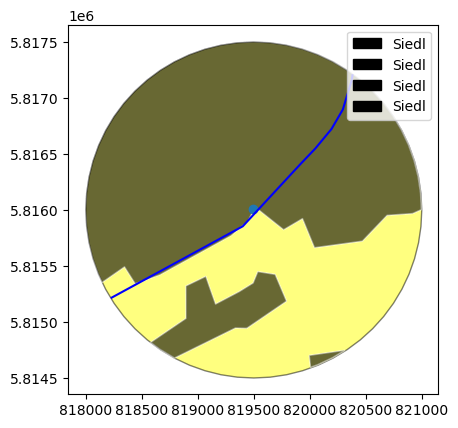

In [81]:
def a_location_marker(a_location, crs:str = "EPSG:4326", to_crs: str = "EPSG:3857"):
    this_location, these_bounds = userdisplay.map_markers(a_location)
    this_geometry = [Point(loc['longitude'], loc['latitude']) for loc in this_location]
    this_shape = gpd.GeoDataFrame(this_location, geometry=this_geometry, crs=crs)
    this_shape = this_shape.to_crs(to_crs)
    return this_shape, these_bounds



sresr = river_results['this_report'].sample_results
these_locations = sresr.location.unique()
a_location = sresr[sresr.location == these_locations[1]].copy()
this_shape, these_bounds = a_location_marker(a_location)

this_buffer = gpd.GeoDataFrame(geometry=this_shape.buffer(1500), crs="epsg:3857")
location_buffer = this_buffer.dissolve()


location_landuse = gpd.overlay(landcover.to_crs('epsg:3857'), location_buffer, how='intersection', keep_geom_type=True)
location_landuse['color'] = location_landuse['land-use'].map(colors)

location_theme = gpd.overlay(rivers, location_buffer, how='intersection', keep_geom_type=True) 
fig, ax = plt.subplots()

location_buffer.plot(color='yellow' , alpha=0.5, edgecolor='black', ax=ax)

legend_elements = []
for ause in location_landuse['land-use'].unique():
    subset = location_landuse[location_landuse['land-use'] == value]
    legend_elements.append(mpatches.Patch(color=subset['color'].unique()[0], label=value))
    subset.plot(ax=ax, color=subset['color'].unique()[0], label=value, edgecolor='white', alpha=0.2)
location_theme.plot(ax=ax, color='blue')
    
this_shape.plot(ax=ax)    
ax.legend(handles=legend_elements)


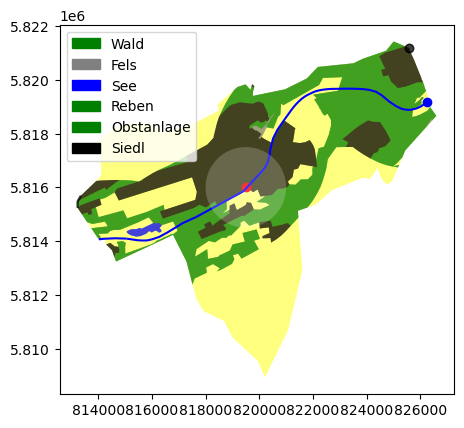

In [71]:



# buffer_gdf = gpd.GeoDataFrame(geometry=rivers.buffer(1500), crs=rivers.crs)
# river_buffer = buffer_gdf.dissolve()

# sresr = river_results['this_report'].sample_results
# # presr = river_results['prior_report'].sample_results

# marker_statsa, map_boundsa = userdisplay.map_markers(ares)
# geometrya = [Point(loc['longitude'], loc['latitude']) for loc in marker_statsa]
# gdfa = gpd.GeoDataFrame(marker_statsa, geometry=geometrya, crs="EPSG:4326")
# gdfa = gdfa.to_crs(epsg=3857)


# marker_stats, map_bounds = userdisplay.map_markers(sres)
# geometry = [Point(loc['longitude'], loc['latitude']) for loc in marker_stats]
# gdf = gpd.GeoDataFrame(marker_stats, geometry=geometry, crs="EPSG:3857")

# marker_statsp, map_boundsp = userdisplay.map_markers(pres)
# geometryp = [Point(loc['longitude'], loc['latitude']) for loc in marker_statsp]
# gdfp = gpd.GeoDataFrame(marker_statsp, geometry=geometryp, crs="EPSG:3857")




fig, ax = plt.subplots()
this_land_use = intersect_landusex[intersect_landusex.city == 'Sion'].copy()
this_city = cities[cities.city == 'Sion'].copy()
this_river = gpd.overlay(rivers, this_city, keep_geom_type=False)


for a_layer in [this_city, this_land_use, this_river, this_shape, kanton, cities, rivers]:

    
    a_layer.to_crs(epsg=3857, inplace=True)




this_city.plot(ax=ax, color='yellow', alpha=0.5)

legend_elements = []
for value in this_land_use['land-use'].unique():
    subset = this_land_use[this_land_use['land-use'] == value]
    legend_elements.append(mpatches.Patch(color=subset['color'].unique()[0], label=value))
    subset.plot(ax=ax, color=subset['color'].unique()[0], label=value, edgecolor=None, alpha=0.2)
this_river.plot(ax=ax, color='blue')
this_shape.plot(ax=ax, color='red')
location_buffer.plot(ax=ax, color='white', alpha=.2, zorder=10)
ax.legend(handles=legend_elements)
plt.show()

In [61]:
this_shape

,sample_id,quantity,pcs/m,date,latitude,longitude,location,geometry
0,1,9,0.18,2020-10-15,46.222049,7.361664,les-vieux-ronquoz,POINT (819496.688 5816004.363)


In [50]:
pres

,sample_id,location,date,quantity,pcs/m
0,"('grand-clos', '2016-09-21')",grand-clos,2016-09-21,1159,41.47
1,"('grand-clos', '2017-10-22')",grand-clos,2017-10-22,183,6.55


In [49]:
ares

,sample_id,location,date,quantity,pcs/m
0,"('grand-clos', '2016-09-21')",grand-clos,2016-09-21,1159,41.47
1,"('grand-clos', '2017-10-22')",grand-clos,2017-10-22,183,6.55
2,"('grand-clos', '2020-05-07')",grand-clos,2020-05-07,510,15.92
3,"('grand-clos', '2020-06-09')",grand-clos,2020-06-09,538,15.88
4,"('grand-clos', '2020-07-07')",grand-clos,2020-07-07,1475,52.73
5,"('grand-clos', '2020-08-06')",grand-clos,2020-08-06,1099,42.31
6,"('grand-clos', '2020-09-08')",grand-clos,2020-09-08,616,13.63
7,"('grand-clos', '2020-10-06')",grand-clos,2020-10-06,581,20.78
8,"('grand-clos', '2020-12-08')",grand-clos,2020-12-08,716,23.03
9,"('grand-clos', '2021-01-07')",grand-clos,2021-01-07,433,6.25


In [48]:
sres

,sample_id,location,date,quantity,pcs/m
0,"('grand-clos', '2020-05-07')",grand-clos,2020-05-07,510,15.92
1,"('grand-clos', '2020-06-09')",grand-clos,2020-06-09,538,15.88
2,"('grand-clos', '2020-07-07')",grand-clos,2020-07-07,1475,52.73
3,"('grand-clos', '2020-08-06')",grand-clos,2020-08-06,1099,42.31
4,"('grand-clos', '2020-09-08')",grand-clos,2020-09-08,616,13.63
5,"('grand-clos', '2020-10-06')",grand-clos,2020-10-06,581,20.78
6,"('grand-clos', '2020-12-08')",grand-clos,2020-12-08,716,23.03
7,"('grand-clos', '2021-01-07')",grand-clos,2021-01-07,433,6.25
8,"('grand-clos', '2021-02-09')",grand-clos,2021-02-09,156,2.58
9,"('grand-clos', '2021-03-09')",grand-clos,2021-03-09,885,49.24


In [53]:
sres = lake_results['this_report'].sample_results
pres = lake_results['prior_report'].sample_results
ares = call_surveys.sample_results

these_locations = sresr.location.unique()


these_markers = [sresr[sresr.location == x] for x in these_locations]




EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


<Axes: >

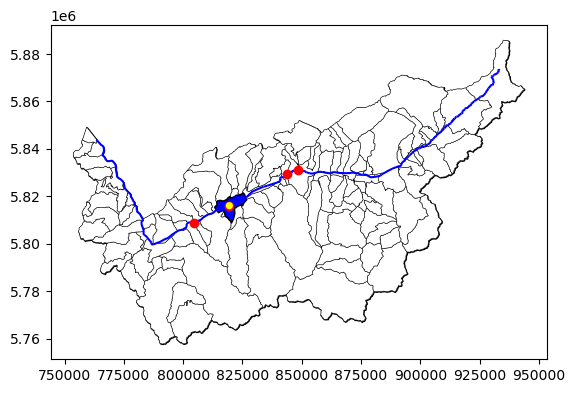

In [67]:
fig, ax = plt.subplots()
# sion.plot(ax=ax, color='yellow', label='Sion', edgecolor='black', alpha=0.2)



kanton.plot(ax=ax, edgecolor='black',color='white')
# trimmedlc.plot(ax=ax, facecolor='green', alpha=.5)
cities.plot(ax=ax, edgecolor='black', color='white', linewidth=.4)
# river_buffer.plot(ax=ax, edgecolor='white', facecolor=None)
this_city.plot(ax=ax, edgecolor='black', color='blue', linewidth=1)
# intersected_gdf.plot(ax=ax, color='white', edgecolor='black')
# intersect_landuse.plot(ax=ax, edgecolor='black', color='green', alpha=.2,linewidth=.4)
rivers.plot(ax=ax, edgecolor='blue')
for thislocation in these_markers:
    amarker, _ = a_location_marker(thislocation)

    if len(amarker) > 0:
        print(amarker.crs)
        
        amarker.plot(ax=ax, color='red', zorder=5)
    else:
        pass
location_buffer.plot(ax=ax, color='yellow', zorder=10)

In [14]:
municategorized.rename(columns={'Siedl':'buildings', 'Wald':'forest', 'Obstanlage':'orchards', 'Reben':'vineyards', 'Undefined':'undefined'}, inplace=True)

uniques = municategorized.drop_duplicates(['buildings', 'forest', 'orchards', 'vineyards', 'undefined'])


o_prior_r = d[(d.canton != canton)&(d['date'] <= o_dates['end'])&(d.feature_type == 'r')].copy()
o_report_r, o_land_use_r = gfcast.make_report_objects(o_prior_r)
newd = o_land_use_r.df_cat.copy()

rate = 1

prior = ((newd['pcs/m'] >= rate)&(newd['date'] < o_dates['end'])).sum()/len(newd[newd['date'] < o_dates['end']])

lhx = d[(d['canton'] == canton)&(d['feature_type'] == 'r')].groupby(['sample_id', 'date'], as_index=False)['pcs/m'].sum()
lh = (lhx['pcs/m'] >= rate).sum()/len(lhx)

def find_matching_records(data, args):
    matches = data[(data[['buildings', 'forest', 'orchards', 'vineyards', 'undefined']] == args).all(axis=1)].copy()
    return matches

# matches = find_matching_records(newd, uniques.values[0])

def what_is_the_binomial_mle(rate, data):
    mle = (data['pcs/m'] >= rate).sum()/len(data)
    return mle

def what_is_the_posterior(data, prior, lh, rate, landuse):
    m = find_matching_records(data, landuse)
    if len(m) > 0:
        p = what_is_the_binomial_mle(rate, m)
        prior_X_mle = lh*p
        failed = (1-lh)*(1-p)
        
        posterior = prior_X_mle/(failed+prior_X_mle)
    else:
        mle_X_prior = lh*prior
        failed = (1-lh)*(1-prior)
        posterior = mle_X_prior/(mle_X_prior+failed)
    return landuse, posterior

def what_is_the_posterior_percity(data, prior, lh, rate, landuses, muni):
    
    res = []
    for landuse in landuses:
        lu, posterior = what_is_the_posterior(data, prior, lh, rate, landuse)
        mu = muni[(muni[['buildings', 'forest', 'orchards', 'vineyards', 'undefined']] == lu).all(axis=1)].copy()
        mu['chance'] = posterior
        res.append(mu)
    return pd.concat(res)
    

chance_of1 = what_is_the_posterior_percity(newd.copy(), prior, lh, rate, uniques.values, municategorized)
thc = thesecities[thesecities.NAME.isin(intersected_gdf.NAME.unique())].merge(chance_of1, right_index=True, left_on='NAME')

NameError: name 'thesecities' is not defined

In [ ]:
# points







# Plot the data
fig, ax = plt.subplots(figsize=(16, 9))

bbox = gpd.GeoDataFrame({"geometry": [box( minx,miny,  maxx, maxy,)]}, crs="EPSG:3857")
dbc.plot(ax=ax, facecolor='black')

thesecities.plot(ax=ax, edgecolor='white', facecolor='None', linewidth=1)
intersected_polygons.plot(ax=ax, facecolor='yellow')
river_buffer.plot(ax=ax, color='blue')

# gdfr.plot(ax=ax, color='yellow', markersize=50, zorder=5)

plt.show()



# Canton Valais

__Density of trash along lakes and rivers__

This is a sample cantonal report. The structure and the format are based off of the federal report, ([IQAASL](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/)). This version is intended for use as a decsion support tool. Thus, the user is expected to be familiar with the results in the federal report and the methods described in the _Guide for Monitoring Marine Litter on European Seas_ 
([The guide](https://mcc.jrc.ec.europa.eu/main/dev.py?N=41&O=439&titre_chap=TG%20Litter&titre_page=Guidance%20for%20the%20Monitoring%20of%20Marine%20Litter)).


:::{dropdown} Initial assessment: stakeholder discussion and priorities.

Stakeholders should consider the following questions while consulting the report:

1. Are the major rivers and lakes included?
2. Was their more or less observed in 2021 vs the prior results?
3. __How do these results compare to assessments from other sources (EAWAG, EMPA, Internal reports)?__
   * This includes reports from NGOS in the region
   * Is the data comparable?
4. Are the objects identified as the _most common_ currently the focus of reduction or prevention campaigns?
   * __How does the canton decide priorties in this regard?__
   * __Did or does the object appear in any regional action plan or strategy?__
5. For objects that have been the focus of prevention or reduction campaigns in the past: are they on the _most common objects_ list now?
   * If the objects are on the most common list, is this inline with expectations ?
   * What excatly was the mechanism or process that was intended to reduce the presence of the object?
   * __With respect to the amount of resources attributed to prevention and mitigation:__ Do the attributed amounts reflect the importance of the object in terms of total amount found and frequency of occurence?
6. __Does the sampling distribution reflect the topography and land-use of the canton?__
7. Do the municipalities with elevated pcs/m have common land-use attributes?
8. __Are the municipalities of strategic importance to the canton included?__
9. Are their locations in the canton that should have been surveyed, according to cantonal priorities?
10. Are their products of regional interest that should be included in the cantonal report?
:::

:::::{dropdown} Map of survey locations



::::{grid}
:padding: 2

:::{grid-item-card}

```{glue} map-of-survey-locations
```

:::
::::
:::::
## Vital statistics

::::::::::{tab-set}

:::::::::{tab-item} All data

::::::::{grid} 2 2 2 2
:gutter: 1

:::::::{grid-item}
:columns: 12 4 4 4

```{glue} feature-inventory
```
```{glue} administrative-boundaries
```
__Material composition__

```{glue} material-report
```
:::::::

:::::::{grid-item-card}
:columns: 12 8 8 8
:shadow: none

```{glue} prior-likelihood
```

+++
```{glue} caption-histo
```
:::::::
::::::::

::::::::{grid} 3 3 3 3 

:::::::{grid-item-card}
:shadow: none
:padding: 1

```{glue} sampling-summary
```
:::::::

:::::::{grid-item-card}
:shadow: none
:padding: 1

```{glue} l-sampling-summary
```
:::::::

:::::::{grid-item-card}
:shadow: none
:padding: 1

```{glue} prior-sampling-summary
```
:::::::

::::::::

:::::::::

:::::::::{tab-item} Lakes

::::::::{grid} 2 2 2 2
:gutter: 1

:::::::{grid-item}
:columns: 12 4 4 4

```{glue} feature-inventory-l
```
```{glue} administrative-boundaries-l
```
__Material composition__

```{glue} material-report-l
```
:::::::

:::::::{grid-item-card}
:columns: 12 8 8 8
:shadow: none

```{glue} lake-prior-likelihood
```

+++
```{glue} caption-histo-l
```
:::::::
::::::::

::::::::{grid} 3 3 3 3 

:::::::{grid-item-card}
:shadow: none
:padding: 1

```{glue} sampling-summary-l
```
:::::::

:::::::{grid-item-card}
:shadow: none
:padding: 1

```{glue} l-sampling-summary-l
```
:::::::

:::::::{grid-item-card}
:shadow: none
:padding: 1

```{glue} prior-sampling-summary-l
```
:::::::

::::::::

:::::::::

:::::::::{tab-item} Rivers

::::::::{grid} 2 2 2 2
:gutter: 1

:::::::{grid-item}
:columns: 12 4 4 4

```{glue} feature-inventory-r
```
```{glue} administrative-boundaries-r
```
__Material composition__

```{glue} material-report-r
```
:::::::

:::::::{grid-item-card}
:columns: 12 8 8 8
:shadow: none

```{glue} river-prior-likelihood
```

+++
```{glue} caption-histo-r
```
:::::::
::::::::

::::::::{grid} 3 3 3 3 

:::::::{grid-item-card}
:shadow: none
:padding: 1

```{glue} sampling-summary-r
```
:::::::

:::::::{grid-item-card}
:shadow: none
:padding: 1

```{glue} l-sampling-summary-r
```
:::::::

:::::::{grid-item-card}
:shadow: none
:padding: 1

```{glue} prior-sampling-summary-r
```
:::::::

::::::::

:::::::::

::::::::::

:::::{dropdown}  How did we get this data ?



::::{grid}
:padding: 2

:::{grid-item-card}

```{glue} scatter-prior-likelihood
```
+++
The data is a combination of observations from variety of groups in Switerland since 2015. The observations were recorded using an interpretation of the _Guide for Monitoring Marine Litter on European Seas_ [The guide](https://mcc.jrc.ec.europa.eu/main/dev.py?N=41&O=439&titre_chap=TG%20Litter&titre_page=Guidance%20for%20the%20Monitoring%20of%20Marine%20Litter). The guide and the monitoring of beach litter are part of decades of research, here is the brief history [A Brief History of Marine Litter Research](https://link.springer.com/chapter/10.1007/978-3-319-16510-3_1).
:::
::::

__Common sense guidance:__

1. The data should be considered as a reasonable estimate of the minimum amount of trash on the ground at the time of the survey.
2. There are many sources of variance. We have considered the following:
   * litter density between sampling groups.
   * litter density with respect to topographical features.
3. There are differences in detect-ability and appearance for items of the same classification that are due to the effects of decomposition.
4. Many surveyors are volunteers and have different levels of experience or physical constraints that limit what will actually be collected and counted.
:::::

:::{dropdown} How to make a report

__Survey and Land use__

A report is the implementation of a `SurveyReport` and a `LandUseReport`. The `SurveyReport` is the basic 
element and does the initial aggregating and descriptive statistics for a query.

The land-use-report accepts `SurveyReport.sample_results` and assigns the land-use attributes to the record. The 
land-use-report provides the baseline assessment of litter density with reference to the surrounding environment. 

The assessment accepts as variables the proportion of available space that a topographical feature occupies in a 
circle of $\pi r² \text{ where r = 1 500 meters}$ and the center of that circle is the survey location. 
These proportions are compared to the `average pieces per meter` for an object or group of objects.


__Create a report__

A report can be intiated by providing the name of the canton. If your canton does not appear this is because we have no data. The prior dates will be calculated automatically, by taking all data prior to the start date of the querry.

```{code} python

import reports
import geospatial
import gridforecast

# suppose you have defined your data into df
observed_dates = {'start':'2020-01-01', 'end':'2021-12-31'}

# everything that was seen before
prior_dates = {'start':'2015-11-15', 'end':'2019-12-31'}

# name the canton
canton = 'Bern'

# define the data of interest
data_of_interest = {'canton':canton, 'date_range':observed_dates}

# load the data
df = session_config.collect_survey_data()

# filter the data. 
filtered_data, locations = gridforeacast.filter_data(df, data_of_interest)

# make a survey report
this_report = reports.SurveyReport(dfc=filtered_data)

# generate the parameters for the landuse report
target_df = this_report.sample_results
features = geospatial.collect_topo_data(locations=target_df.location.unique())

# make a landuse report
this_land_use = geospatial.LandUseReport(target_df, features)
```

Each report and the inference method are documented: [SurveyReport](surveyreporter), [LandUseReport](landusereporter), [GridForecaster](gridforecaster)
:::


## Most common objects 2020 - 2021

::::::::::{tab-set}

:::::::::{tab-item} All data
::::{grid} 2 2 2 2 
:::{grid-item}
:columns: 4

```{glue} ratio-most-common
```

The most common objects from the selected data. The most common objects are a combination of the top ten most abundant objects and those objects that are found in more than 50% of the samples. Some objects are found frequently but at low quantities.Other objects are found in fewer samples but at higher quantities.


:::

:::{grid-item-card}
:columns: 8
:shadow: none

```{glue} most_common_objects
:::
::::
:::::::::

:::::::::{tab-item} Lakes
::::{grid} 2 2 2 2 
:::{grid-item}
:columns: 4

```{glue} ratio-most-common-l
```

The most common objects from the selected data. The most common objects are a combination of the top ten most abundant objects and those objects that are found in more than 50% of the samples. Some objects are found frequently but at low quantities.Other objects are found in fewer samples but at higher quantities.


:::

:::{grid-item-card}
:columns: 8
:shadow: none

```{glue} most_common_objects-l
:::
::::
:::::::::

:::::::::{tab-item} Rivers
::::{grid} 2 2 2 2 
:::{grid-item}
:columns: 4

```{glue} ratio-most-common-r
```

The most common objects from the selected data. The most common objects are a combination of the top ten most abundant objects and those objects that are found in more than 50% of the samples. Some objects are found frequently but at low quantities.Other objects are found in fewer samples but at higher quantities.


:::

:::{grid-item-card}
:columns: 8
:shadow: none

```{glue} most_common_objects-r
:::
::::
:::::::::

::::::::::

:::{dropdown} Defining the most common objects

The default method for defining _the most common objects_ is based on the number of items collected and the number of times that at least one of an object was found with respect to the number of surveys in the query, the _fail rate_.

Adjusting the fail rate will increase or decrease the number of the most common objects. The fail rate is included with the object inventory. 

```{code} python

# the most common objects are accesible in the survey report
# the report.object_summary method aggregates the data to code
# and attaches the fail rate and % of total
inventory = this_report.object_summary()

# userdisplay.most_common, takes the 10 most abundant and filters
# the data for fail rate >= 0.5. The method returns a formatted table,
# a list of the codes and the ratio of the quantity of the most common to the whole 
mostcommon, codes, ratio = userdisplay.most_common(inventory)

```


:::

## Land use


Land use refers to the measurable topographic features within a cirlce of r = 1 500 m and area = $\pi r²$ with the survey location in the middle. The features, measured in meters squared, are given as a ratio $\frac{\text{area of feature}}{\text{area of circle}}$. Thus a location with high percentage of buildings will have a rating or value between 60% and 100%. The pcs/m rating is the average of all locations with a land-use profile of the same rating.

In [ ]:
g = results['this_land_use'].n_samples_per_feature().copy()
g = userdisplay.landuse_profile(g[session_config.feature_variables[:-1]], nsamples=results['this_report'].number_of_samples)
g = g.set_caption("")

gt = results['this_land_use'].rate_per_feature().copy()
gt = userdisplay.litter_rates_per_feature(gt.loc[session_config.feature_variables[:-1]])
gt = gt.set_caption("")

glue('rate-per-feature', gt, display=False)
glue('sampling-profile', g, display=False)

In [ ]:
streets = results['this_land_use'].n_samples_per_feature().copy()
streets = streets[[session_config.feature_variables[-1]]].copy()
streets = userdisplay.street_profile(streets.T, nsamples=results['this_report'].number_of_samples)
caption = ""
streets = streets.set_caption(caption)

streets_r = results['this_land_use'].rate_per_feature().copy()
streets_r = streets_r.loc[[session_config.feature_variables[-1]]].copy()
streets_r = userdisplay.street_profile(streets_r, nsamples=results['this_report'].number_of_samples, caption='rate')
caption = ""
streets_r = streets_r.set_caption(caption)

glue('street-profile', streets, display=False)
glue('street-rates-feature', streets_r, display=False)

In [ ]:
gl = lake_results['this_land_use'].n_samples_per_feature().copy()
gl = userdisplay.landuse_profile(gl[session_config.feature_variables[:-1]], nsamples=lake_results['this_report'].number_of_samples)
gl = gl.set_caption("")

gtl = lake_results['this_land_use'].rate_per_feature().copy()

gtl = userdisplay.litter_rates_per_feature(gtl.loc[session_config.feature_variables[:-1]])
gtl = gtl.set_caption("")

glue('lake-rate-per-feature', gtl, display=False)
glue('lake-sampling-profile', gl, display=False)

In [ ]:
streets_p = lake_results['this_land_use'].n_samples_per_feature().copy()
streets_p = streets_p[[session_config.feature_variables[-1]]].copy()
streets_p = userdisplay.street_profile(streets_p.T, nsamples=lake_results['this_report'].number_of_samples)
caption = ""
streets_p = streets_p.set_caption(caption)

streets_r_l = lake_results['this_land_use'].rate_per_feature().copy()
streets_r_l = streets_r_l.loc[[session_config.feature_variables[-1]]].copy()
streets_r_l = userdisplay.street_profile(streets_r_l, nsamples=lake_results['this_report'].number_of_samples, caption='rate')
caption = ""
streets_r_l = streets_r_l.set_caption(caption)


glue('lake-street-profile', streets_p, display=False)
glue('lake-street-rates-feature', streets_r_l, display=False)

In [ ]:
gr = river_results['this_land_use'].n_samples_per_feature().copy()
gr = userdisplay.landuse_profile(gr[session_config.feature_variables[:-1]], nsamples=river_results['this_report'].number_of_samples)
gr = gr.set_caption("")

gtlr = river_results['this_land_use'].rate_per_feature().copy()

gtlr = userdisplay.litter_rates_per_feature(gtlr.loc[session_config.feature_variables[:-1]])
gtlr = gtlr.set_caption("")


glue('river-rate-per-feature', gtlr, display=False)
glue('river-sampling-profile', gr, display=False)

In [ ]:
streets_p_r = river_results['this_land_use'].n_samples_per_feature().copy()
streets_p_r = streets_p_r[[session_config.feature_variables[-1]]].copy()
streets_p_r = userdisplay.street_profile(streets_p_r.T, nsamples=river_results['this_report'].number_of_samples)
caption = ""
streets_p_r = streets_p_r.set_caption(caption)

streets_r_r = river_results['this_land_use'].rate_per_feature().copy()
streets_r_r = streets_r_r.loc[[session_config.feature_variables[-1]]].copy()
streets_r_r = userdisplay.street_profile(streets_r_r, nsamples=river_results['this_report'].number_of_samples, caption='rate')
caption = ""
streets_r_r = streets_r_r.set_caption(caption)


glue('river-street-profile', streets_p_r, display=False)
glue('river-street-rates-feature', streets_r_r, display=False)

1. The rate per feature refers to the average pcs/m observed at a particular land use rate
   * Under what conditions is the pcs/m elevated? Where is it the least?
2. The sampling profile refers to the ratio of samples that were taken at a particular land use rate
   * Does the sampling profile reflect the topography of the region?



### Rate per feature 2020 - 2021

::::{tab-set}
:::{tab-item} All lakes and rivers

__Land use__

```{glue} rate-per-feature
```

__Streets__

The streets are measured as the length of the road network in the cirlce with r= 1 500 m and area $\pi r²$ and the survey location in the middle. The lenghts for each location are normalized from 0 - 1. Thus in the table below, the locations that have the shortest road net work will be in category 1, the those with a more dense network will be higher.
<br></br>

```{glue} street-rates-feature
``` 
:::

:::{tab-item} Lakes

__Land use__

```{glue} lake-rate-per-feature
```

__Streets__

The streets are measured as the length of the road network in the cirlce with r= 1 500 m and area $\pi r²$ and the survey location in the middle. The lenghts for each location are normalized from 0 - 1. Thus in the table below, the locations that have the shortest road net work will be in category 1, the those with a more dense network will be higher.
<br></br>

```{glue} lake-street-rates-feature
```
:::

:::{tab-item} Rivers

__Land use__

```{glue} river-rate-per-feature
```

__Streets__

The streets are measured as the length of the road network in the cirlce with r= 1 500 m and area $\pi r²$ and the survey location in the middle. The lenghts for each location are normalized from 0 - 1. Thus in the table below, the locations that have the shortest road net work will be in category 1, the those with a more dense network will be higher.
<br></br>

```{glue} river-street-rates-feature
``` 
:::

::::

### Sampling profile 2020 - 2021

::::{tab-set}
:::{tab-item} All lakes and rivers

__Land use__


```{glue} sampling-profile
```

__Streets__

The streets are measured as the length of the road network in the cirlce with r= 1 500 m and area $\pi r²$ and the survey location in the middle. The lengths for each location are normalized from 0 - 1. Thus in the table below, the locations that have the shortest road net work will be in category 1, the those with a more dense network will be higher.
<br></br>

```{glue} street-profile
``` 
:::

:::{tab-item} Lakes

__Land use__

```{glue} lake-sampling-profile
```

__Streets__

The streets are measured as the length of the road network in the cirlce with r= 1 500 m and area $\pi r²$ and the survey location in the middle. The lenghts for each location are normalized from 0 - 1. Thus in the table below, the locations that have the shortest road net work will be in category 1, the those with a more dense network will be higher.
<br></br>

```{glue} lake-street-profile
:::

:::{tab-item} Rivers

__Land use__

```{glue} river-sampling-profile
```

__Streets__

The streets are measured as the length of the road network in the cirlce with r= 1 500 m and area $\pi r²$ and the survey location in the middle. The lenghts for each location are normalized from 0 - 1. Thus in the table below, the locations that have the shortest road net work will be in category 1, the those with a more dense network will be higher.
<b></b>

```{glue} river-street-profile
``` 
:::

::::

:::{dropdown} Defining land use

__Land cover__

These measured land-use attributes are the labeled polygons from the map layer Landcover defined here ([swissTLMRegio product information](https://www.swisstopo.admin.ch/fr/modele-du-territoire-swisstlm3d#dokumente)), they are extracted using vector overlay techniques in QGIS ([QGIS](https://qgis.org/en/site/)).

* Buildings: built up, urbanized
* Woods: not a park, harvesting of trees may be active
* Vineyards: does not include any other type of agriculture
* Orchards: not vineyards
* Undefined: areas of the map with no predefined label


```{code}

# the land use is summarized using a LandUseReport object
# the average pieces per meter by land use category
rate_per_feature = this_land_use.n_pieces_per_feature()

# the sampling distribution
samples_per_feature = this_land_use.n_samples_per_feature()

# the variety of locations per feature
locations_per_feature = this_land_use.locations_per_feature()

# format for display .html
styled_rate_per_feature = userdisplay.litter_rates_per_feature(rate_per_feature)
```

__Public services__

Public services are the labled polygons from the Freizeitareal and Nutzungsareal map layers, defined in ([swissTLMRegio product information](https://www.swisstopo.admin.ch/fr/modele-du-territoire-swisstlm3d#dokumente)). Both layers represent areas used for specific activities. Freizeitareal identifies areas used for recreational purposes and Nutzungsareal represents areas such as hospitals, cemeteries, historical sites or incineration plants. As a ratio of the available dry-land in a hex, these features are relatively small (less than 10%) of the total dry-land. For identified features within a bounding hex the magnitude in meters² of these variables is scaled between 0 and 1, thus the scaled value represents the size of the feature in relation to all other measured values for that feature from all other hexagons.

* Recreation: parks, sports fields, attractions
* Infrastructure: Schools, Hospitals, cemeteries, powerplants

__Streets and roads__

Streets and roads are the labled polylines from the TLM Strasse map layer defined in ([swissTLMRegio product information](https://www.swisstopo.admin.ch/fr/modele-du-territoire-swisstlm3d#dokumente)). All polyines from the map layer within a bounding hex are merged (disolved in QGIS commands) and the combined length of the polylines, in meters, is the magnitude of the variable for the bounding hex.
:::

## Forecast

::::::::::{tab-set}

:::::::::{tab-item} All data
::::{grid} 1 1 2 2

:::{grid-item-card}
:columns: 12 5 5 5 

Minimum expected survey results 2025
^^^


```{glue} forecast-99-max
```
```{glue} forecast-weighted-prior
```

```{glue} forecast-max-val
```

:::

:::{grid-item-card}
:columns: 12 7 7 7 
:shadow: none
```{glue} cumumlative-dist-forecast-prior
```
+++
Cumulative distribution of observed, sampling history and forecasts using to different priors.
:::
::::
:::::::::

:::::::::{tab-item} Lakes
::::{grid} 1 1 2 2

:::{grid-item-card}
:columns: 12 5 5 5 

Minimum expected survey results 2025
^^^


```{glue} forecast-99-max-l
```

```{glue} forecast-weighted-prior-l
```

```{glue} forecast-max-val-l
```


:::

:::{grid-item-card}
:columns: 12 7 7 7 
:shadow: none
```{glue} lake-cumumlative-dist-forecast-prior
```
+++
Cumulative distribution of observed, sampling history and forecasts using to different priors.
:::
::::
:::::::::

:::::::::{tab-item} Rivers
::::{grid} 1 1 2 2

:::{grid-item-card}
:columns: 12 5 5 5 

Minimum expected survey results 2025
^^^


```{glue} forecast-99-max-r
```

```{glue} forecast-weighted-prior-r
```

```{glue} forecast-max-val-r
```


:::

:::{grid-item-card}
:columns: 12 7 7 7 
:shadow: none
```{glue} river-cumumlative-dist-forecast-prior
```
+++
Cumulative distribution of observed, sampling history and forecasts using to different priors.
:::
::::
:::::::::

::::::::::

:::{dropdown} Forecast methods

The applied method would best be classified as Empirical Bayes, in the sense that the prior is derived from the data ([Bayesian Filtering and Smoothing](https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf) or [Empirical Bayes methods in classical and Bayesian inference](https://hannig.cloudapps.unc.edu/STOR757Bayes/handouts/PetroneEtAl2014.pdf)). However, we share the concerns of Davidson-Pillon [Bayesian methods for hackers](https://dataorigami.net/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents) about double counting and eliminate it the possibility as part of the formulation of the prior. 

__Model assumptions__

1. Locations with similar land use attributes will have similar litter density rates
2. The data is a best estimate of what was present on the day of the survey
3. There are regional differences with respect to the density of specific objects
4. The locations surveyed are maintained by a public administration

The choice of land use features was a natural choice but was further explored in [Near or Far](https://hammerdirt-analyst.github.io/landuse/titlepage.html).

Our parameter estimates are thus derived from the data and they remain testable and quantifiable according to [Prior Probabilities, E T Jaynes](https://bayes.wustl.edu/etj/articles/prior.pdf). This makes our calculation very repetetive but also very well understood. It can be defined in a few lines of code for any set of survey results.

```{code} python

# standared libaries
import numpy as np
from scipy.stats import dirichlet, multinomial

# collect the data of interest
h = array of survey values

# count the number of times that each survey values exceed a value on the gird
counts = np.array([np.sum((h > x) & (h <= x + .1)) for x in grid_range])

# use the dirichlet dist to estimate p(Y >= x) for each x on the grid
# and sample from the estimation
adist = dirichlet(counts)
this_dist = adist.rvs(1-[0]

# draw samples from the conjugate
posterior_samples = multinomial.rvs(nsamples, p=this_dist)

```
:::

In [ ]:
dxl = call_l_surveys.df
dxf = call_l_land.df_cont

dxlc = dxl[['location', 'city', 'feature_type']].drop_duplicates('location')
dxlc.set_index(['location'], inplace=True, drop=True)
dxf['city'] = dxf.location.apply(lambda x : dxlc.loc[x, 'city'])
sumlu = {x:'sum' for x in session_config.feature_variables}
dxf = dxf.groupby(['sample_id', 'city', *session_config.feature_variables], as_index=False).agg(session_config.unit_agg)

dxf = dxf.groupby(['city']).agg({'quantity':'sum', 'pcs/m':'mean', 'sample_id':'nunique', **sumlu})

for alabel in session_config.feature_variables:
    dxf[alabel] = dxf[alabel]/dxf.sample_id
    
dxf['check'] = dxf[session_config.feature_variables[:-1]].sum(axis=1)
dxfc = geospatial.categorize_features(dxf, feature_columns=session_config.feature_variables)
dxfc.rename(columns={'sample_id':'samples'}, inplace=True)
dxfc.drop('check', axis=1, inplace=True)
dxfc = dxfc.style.set_table_styles(userdisplay.table_css_styles)
dxfc = dxfc.apply(highlight_max, arg=lake_results['this_report'].sampling_results_summary['average'], subset=pd.IndexSlice[:, ['pcs/m']])
dxfc = dxfc.format(userdisplay.format_kwargs, precision=2)

glue('lake-municipal-results', dxfc , display=False)

In [ ]:
dxl = call_r_surveys.df
dxf = call_r_land.df_cont

dxlc = dxl[['location', 'city', 'feature_type']].drop_duplicates('location')
dxlc.set_index(['location'], inplace=True, drop=True)
dxf['city'] = dxf.location.apply(lambda x : dxlc.loc[x, 'city'])
sumlu = {x:'sum' for x in session_config.feature_variables}
dxf = dxf.groupby(['sample_id', 'city', *session_config.feature_variables], as_index=False).agg(session_config.unit_agg)

dxf = dxf.groupby(['city']).agg({'quantity':'sum', 'pcs/m':'mean', 'sample_id':'nunique', **sumlu})

for alabel in session_config.feature_variables:
    dxf[alabel] = dxf[alabel]/dxf.sample_id
    
dxf['check'] = dxf[session_config.feature_variables[:-1]].sum(axis=1)
dxfcr = geospatial.categorize_features(dxf, feature_columns=session_config.feature_variables)
dxfcr.rename(columns={'sample_id':'samples'}, inplace=True)
dxfcr.drop('check', axis=1, inplace=True)
dxfcr = dxfcr.style.set_table_styles(userdisplay.table_css_styles)
dxfcr = dxfcr.apply(highlight_max, arg=lake_results['this_report'].sampling_results_summary['average'], subset=pd.IndexSlice[:, ['pcs/m']])
dxfcr = dxfcr.format(userdisplay.format_kwargs, precision=2)
# glue('all-data-municipal-results', i , display=False)
glue('river-municipal-results', dxfcr, display=False)


In [ ]:
summardata = alldata_ofinterest.groupby(['sample_id', 'feature_type','feature_name'], as_index=False).agg({'pcs/m':'sum'})
# lakes
feature_individual_summary = summardata.groupby(['feature_type','feature_name'], as_index=False).agg({'sample_id':'nunique', 'pcs/m':'mean'})

lakes_individual_summary = feature_individual_summary[feature_individual_summary.feature_type == 'l'].copy()
rivers_individual_summary = feature_individual_summary[feature_individual_summary.feature_type == 'r'].copy()


    
lakes_i_sum = format_river_lake_summary(lakes_individual_summary).style.set_table_styles(userdisplay.table_css_styles).format(precision=2)
rivers_i_sum = format_river_lake_summary(rivers_individual_summary).style.set_table_styles(userdisplay.table_css_styles).format(precision=2)

glue('lakes-i-summary', lakes_i_sum, display=False)
glue('rivers-i-summary', rivers_i_sum, display=False)

## Lakes and rivers sampled - all data

::::{grid} 2 2 2 2

:::{grid-item}
**Lakes sampled**

```{glue} lakes-i-summary
```

:::

:::{grid-item}
**Rivers sampled**

```{glue} rivers-i-summary
```
:::
::::

## Municipal Results - all data

The average pieces per meter and the combined land use classification for each city.

::::::::::{tab-set}

:::::::::{tab-item} Lakes
```{glue} lake-municipal-results
```
:::::::::

:::::::::{tab-item} Rivers
```{glue} river-municipal-results
``` 
:::::::::

::::::::::